Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [70]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

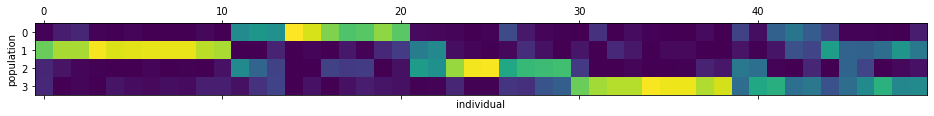

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [11]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [12]:
print(prior_params_dict)

{'dp_prior_alpha': array([3.]), 'allele_prior_alpha': array([1.]), 'allele_prior_beta': array([1.])}


# Get VB params 

In [13]:
k_approx = 12

In [14]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [15]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 11) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 11) (lb=0.0001, ub=inf)


## Initialize 

In [16]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks, 
                                                seed = 412)

In [17]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

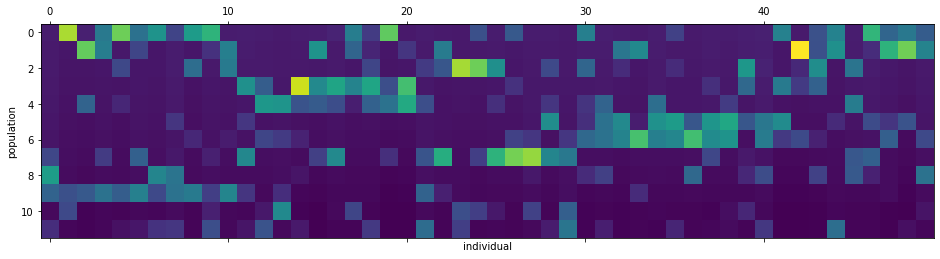

In [18]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Run CAVI

In [19]:
# get beta parameters for sticks and populations
vb_opt_dict, vb_opt, ez_opt, _, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20)


iteration [20]; kl:8200.201224; elapsed: 0.683secs
iteration [40]; kl:7977.817008; elapsed: 0.6958secs
iteration [60]; kl:7823.383367; elapsed: 0.6823secs
iteration [80]; kl:7788.260412; elapsed: 0.7658secs
iteration [100]; kl:7756.791973; elapsed: 0.7888secs
iteration [120]; kl:7750.510824; elapsed: 0.7937secs
iteration [140]; kl:7745.703836; elapsed: 0.7335secs
iteration [160]; kl:7728.543424; elapsed: 0.7489secs
iteration [180]; kl:7704.637801; elapsed: 0.7193secs
iteration [200]; kl:7678.660644; elapsed: 0.711secs
iteration [220]; kl:7614.152068; elapsed: 0.7929secs
iteration [240]; kl:7552.157314; elapsed: 0.6925secs
iteration [260]; kl:7551.820115; elapsed: 0.6753secs
iteration [280]; kl:7551.807349; elapsed: 0.6679secs
CAVI done. Termination after 289 steps in 10.49 seconds


In [20]:
(vb_opt**2).mean()

2.097429025808762

In [21]:
(ez_opt**2).mean()

0.058947247845348584

# Check out the fit

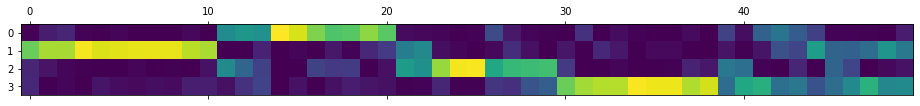

In [22]:
# truth
plt.matshow(true_ind_admix_propn.T)

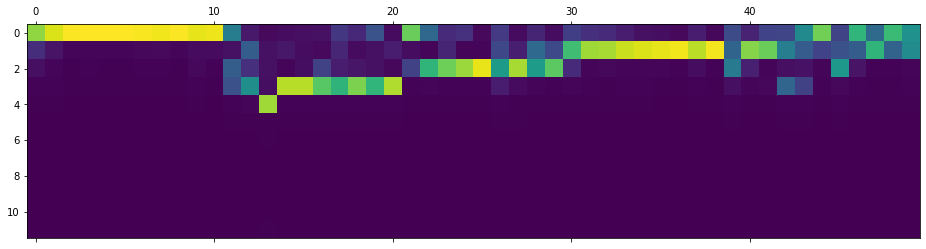

In [23]:
# fitted
e_ind_admix = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0]
plt.matshow(e_ind_admix.T)

# Define prior perturbation

In [24]:
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

In [25]:
def log_phi(logit_v):
    return(sp.special.expit(-logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [26]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))

def rescaled_log_phi(logit_v):
    return 2 * log_phi(logit_v) / log_phi_max


In [27]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)


-1.0986122886681098 1.5674499614238597 -1.0996184973479006 1.5669044626347488


In [28]:
log_prior_pert = lambda logit_v : rescaled_log_phi(logit_v) - prior_perturbation.log_norm_pc_logit

In [29]:
# we will use theses for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_perturbed_kl(
                                                        g_obs, 
                                                        params,
                                                        epsilon,
                                                        log_prior_pert,
                                                        prior_params_dict, 
                                                        gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)
    
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon, gh_loc, gh_weights): 
    return func_sens_lib.get_e_log_perturbation(log_phi,
                            vb_params_dict['ind_mix_stick_propn_mean'],
                            vb_params_dict['ind_mix_stick_propn_info'],
                            epsilon, gh_loc, gh_weights, sum_vector=True)


hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: get_e_log_perturbation(log_prior_pert, 
                                                    params,
                                                    epsilon,
                                                    gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [30]:
epsilon0 = np.array([0.])

In [31]:
# get preconditioner 
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.377sec


In [32]:
obj_fun_hvp = autograd.hessian_vector_product(get_epsilon_vb_loss, argnum = 0)

hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, epsilon0, x), 
                                                        dim = len(vb_opt), 
                                                        cg_opts={'M':mfvb_preconditioner})

    
t0 = time.time()
epsilon_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = get_epsilon_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value = epsilon0, 
        hess_solver = hess_solver, 
        hyper_par_objective_fun = hyper_par_objective_fun)

print('derivative time: {}sec'.format(np.round(time.time() - t0, 3)))

cross hess time:  0.7587759494781494
solver time:  3.472550392150879
derivative time: 4.232sec


# Fit with perturbation

In [33]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  12.622706298840754


In [34]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

In [35]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [36]:
vb_pert_dict, vb_opt_pert, e_z_pert, _, _ = \
    cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                        vb_params_paragami, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20, 
                        epsilon = epsilon, log_phi = log_prior_pert)


iteration [20]; kl:7632.566749; elapsed: 0.7578secs
iteration [40]; kl:7631.90689; elapsed: 0.7087secs
iteration [60]; kl:7631.753456; elapsed: 0.718secs
iteration [80]; kl:7631.656945; elapsed: 0.7822secs
iteration [100]; kl:7631.586762; elapsed: 0.8651secs
iteration [120]; kl:7631.559159; elapsed: 0.7612secs
iteration [140]; kl:7631.552836; elapsed: 1.2104secs
CAVI done. Termination after 152 steps in 6.43 seconds


In [41]:
(vb_opt**2).mean()

2.097429025808762

In [42]:
(lr_vb_free_params**2).mean()

2.306429096401479

In [43]:
(vb_opt_pert**2).mean()

2.2825271769377284